This example shows how to perform a geometry optimization of a water molecule and compute
the vibrational normal modes using GFN1-xTB. 

If you do not have
a DFTB license, remove the line with DFTB settings and instead set
``settings.input.ForceField.Type = 'UFF'``

## Initial imports

In [1]:
from scm.plams import *

# this line is not required in AMS2025+
init()

PLAMS working folder: /path/plams/examples/WaterOptimization/plams_workdir


## Initial structure

In [2]:
# You could also load the geometry from an xyz file:
# molecule = Molecule('path/my_molecule.xyz')
# or generate a molecule from SMILES:
# molecule = from_smiles('O')
molecule = Molecule()
molecule.add_atom(Atom(symbol="O", coords=(0, 0, 0)))
molecule.add_atom(Atom(symbol="H", coords=(1, 0, 0)))
molecule.add_atom(Atom(symbol="H", coords=(0, 1, 0)))

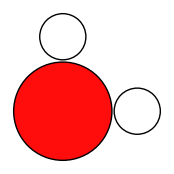

In [3]:
try:
    plot_molecule(molecule)  # plot molecule in a Jupyter Notebook in AMS2023+
except NameError:
    pass

## Calculation settings

The calculation settings are stored in a ``Settings`` object, which is a type of nested dictionary.

In [4]:
settings = Settings()
settings.input.ams.Task = "GeometryOptimization"
settings.input.ams.Properties.NormalModes = "Yes"
settings.input.DFTB.Model = "GFN1-xTB"
# settings.input.ForceField.Type = 'UFF' # set this instead of DFTB if you do not have a DFTB license. You will then not be able to extract the HOMO and LUMO energies.

## Create an AMSJob

In [5]:
job = AMSJob(molecule=molecule, settings=settings, name="water_optimization")

You can check the input to AMS by calling the ``get_input()`` method:

In [6]:
print("-- input to the job --")
print(job.get_input())
print("-- end of input --")

-- input to the job --
Properties
  NormalModes Yes
End

Task GeometryOptimization

System
  Atoms
              O       0.0000000000       0.0000000000       0.0000000000
              H       1.0000000000       0.0000000000       0.0000000000
              H       0.0000000000       1.0000000000       0.0000000000
  End
End

Engine DFTB
  Model GFN1-xTB
EndEngine


-- end of input --


## Run the job

In [7]:
job.run();

[11.02|10:08:21] JOB water_optimization STARTED
[11.02|10:08:21] JOB water_optimization RUNNING
[11.02|10:08:22] JOB water_optimization FINISHED
[11.02|10:08:22] JOB water_optimization SUCCESSFUL


## Main results files: ams.rkf and dftb.rkf

The paths to the main binary results files ``ams.rkf`` and ``dftb.rkf`` can be retrieved as follows:

In [8]:
print(job.results.rkfpath(file="ams"))
print(job.results.rkfpath(file="engine"))

/path/plams/examples/WaterOptimization/plams_workdir/water_optimization/ams.rkf
/path/plams/examples/WaterOptimization/plams_workdir/water_optimization/dftb.rkf


## Optimized coordinates

In [9]:
optimized_molecule = job.results.get_main_molecule()

print("Optimized coordinates")
print("---------------------")
print(optimized_molecule)
print("---------------------")

Optimized coordinates
---------------------
  Atoms: 
    1         O       0.066921       0.066921       0.000000
    2         H       1.012042      -0.078963       0.000000
    3         H      -0.078963       1.012042       0.000000

---------------------


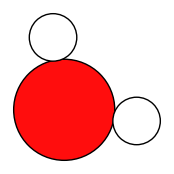

In [10]:
try:
    plot_molecule(optimized_molecule)  # plot molecule in a Jupyter Notebook in AMS2023+
except NameError:
    pass

## Optimized bond lengths and angle

Unlike python lists, where the index of the first element is 0, 
the index of the first atom in the molecule object is 1.

In [11]:
bond_length = optimized_molecule[1].distance_to(optimized_molecule[2])
print("O-H bond length: {:.3f} angstrom".format(bond_length))

O-H bond length: 0.956 angstrom


In [12]:
bond_angle = optimized_molecule[1].angle(optimized_molecule[2], optimized_molecule[3])
print("Bond angle  : {:.1f} degrees".format(Units.convert(bond_angle, "rad", "degree")))

Bond angle  : 107.5 degrees


## Calculation timing

In [13]:
timings = job.results.get_timings()

print("Timings")
print("-------")
for key, value in timings.items():
    print(f"{key:<20s}: {value:.3f} seconds")
print("-------")

Timings
-------
elapsed             : 0.982 seconds
system              : 0.060 seconds
cpu                 : 0.714 seconds
-------


## Energy

In [14]:
energy = job.results.get_energy(unit="kcal/mol")

print("Energy      : {:.3f} kcal/mol".format(energy))

Energy      : -3618.400 kcal/mol


## Vibrational frequencies

In [15]:
frequencies = job.results.get_frequencies(unit="cm^-1")

print("Frequencies")
print("-----------")
for freq in frequencies:
    print(f"{freq:.3f} cm^-1")
print("-----------")

Frequencies
-----------
1427.924 cm^-1
3674.507 cm^-1
3785.960 cm^-1
-----------


##  Dipole moment

In [16]:
import numpy as np

try:
    dipole_moment = np.linalg.norm(np.array(job.results.get_dipolemoment()))
    dipole_moment *= Units.convert(1.0, "au", "debye")
    print("Dipole moment: {:.3f} debye".format(dipole_moment))
except KeyError:
    print("Couldn't extract the dipole moment")

Dipole moment: 1.830 debye


## HOMO, LUMO, and HOMO-LUMO gap

Note: The methods for extracting HOMO, LUMO, and HOMO-LUMO gap only exist in AMS2023 and later.

In [17]:
try:
    homo = job.results.get_homo_energies(unit="eV")[0]
    lumo = job.results.get_lumo_energies(unit="eV")[0]
    homo_lumo_gap = job.results.get_smallest_homo_lumo_gap(unit="eV")

    print("HOMO        : {:.3f} eV".format(homo))
    print("LUMO        : {:.3f} eV".format(lumo))
    print("HOMO-LUMO gap : {:.3f} eV".format(homo_lumo_gap))
except AttributeError:
    print("Methods to extract HOMO and LUMO require AMS2023 or later")
except KeyError:
    print("Couldn't extract the HOMO and LUMO.")

HOMO        : -13.593 eV
LUMO        : -4.206 eV
HOMO-LUMO gap : 9.387 eV


## Read results directly from binary .rkf files

You can also read results directly from the binary .rkf files. Use the "expert mode" of the KFbrowser program that comes with AMS to find out which section and variable to read.

Below, we show how to extract the ``AMSResults%Energy`` variable from the dftb.rkf file. This is the same number that was extracted previously using the ``job.results.get_energy()`` method.

In [18]:
energy = job.results.readrkf("AMSResults", "Energy", file="engine")
print(f"Energy from the engine .rkf file (in hartree): {energy}")

Energy from the engine .rkf file (in hartree): -5.766288141081021
